In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set environment variable to avoid KMeans memory leak warning on Windows
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [22]:
# Load the social media dataset
df = pd.read_csv("Downloads/social_media_data.csv")

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nFirst Few Rows:")
df.head()

Dataset Shape: (20, 7)

Column Names: ['content_type', 'caption_length', 'hashtag_count', 'posting_hour', 'likes', 'comments', 'shares']

Data Types:
 content_type      object
caption_length     int64
hashtag_count      int64
posting_hour       int64
likes              int64
comments           int64
shares             int64
dtype: object

First Few Rows:


,content_type,caption_length,hashtag_count,posting_hour,likes,comments,shares
0,photo,80,5,18,120,12,3
1,photo,150,8,20,95,9,1
2,carousel,110,7,19,240,32,10
3,carousel,140,4,18,210,21,6
4,video,90,6,21,400,58,35


In [23]:
# Display comprehensive statistical summary of numerical columns
print("Statistical Summary:")
df.describe()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check unique values in categorical columns (if any)
if 'content_type' in df.columns:
    print("\nContent Type Distribution:")
    print(df['content_type'].value_counts())

Statistical Summary:

Missing Values:
content_type      0
caption_length    0
hashtag_count     0
posting_hour      0
likes             0
comments          0
shares            0
dtype: int64

Content Type Distribution:
content_type
photo          5
carousel       5
video          5
event_recap    5
Name: count, dtype: int64


In [ ]:
# Exploratory Data Analysis: Visualizations to understand the data patterns

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribution of likes
axes[0, 0].hist(df['likes'], bins=10, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Likes')
axes[0, 0].set_xlabel('Likes')
axes[0, 0].set_ylabel('Frequency')

# Distribution of comments
axes[0, 1].hist(df['comments'], bins=10, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribution of Comments')
axes[0, 1].set_xlabel('Comments')
axes[0, 1].set_ylabel('Frequency')

# Distribution of shares
axes[0, 2].hist(df['shares'], bins=10, color='salmon', edgecolor='black')
axes[0, 2].set_title('Distribution of Shares')
axes[0, 2].set_xlabel('Shares')
axes[0, 2].set_ylabel('Frequency')

# Caption length vs Engagement
if 'engagement' in df.columns:
    engagement_col = 'engagement'
else:
    engagement_col = df['likes'] + df['comments'] + df['shares']
axes[1, 0].scatter(df['caption_length'], engagement_col, alpha=0.6, color='purple')
axes[1, 0].set_title('Caption Length vs Engagement')
axes[1, 0].set_xlabel('Caption Length')
axes[1, 0].set_ylabel('Engagement')

# Hashtag count vs Engagement
axes[1, 1].scatter(df['hashtag_count'], engagement_col, alpha=0.6, color='orange')
axes[1, 1].set_title('Hashtag Count vs Engagement')
axes[1, 1].set_xlabel('Hashtag Count')
axes[1, 1].set_ylabel('Engagement')

# Posting hour vs Average Engagement
hourly_engagement = df.groupby('posting_hour').agg({
    'likes': 'mean',
    'comments': 'mean',
    'shares': 'mean'
})
hourly_total = hourly_engagement.sum(axis=1)
axes[1, 2].bar(hourly_total.index, hourly_total.values, color='teal')
axes[1, 2].set_title('Average Engagement by Posting Hour')
axes[1, 2].set_xlabel('Posting Hour')
axes[1, 2].set_ylabel('Average Engagement')
axes[1, 2].set_xticks(range(int(df['posting_hour'].min()), int(df['posting_hour'].max())+1))

plt.tight_layout()
plt.show()

# Correlation heatmap
if len(df.select_dtypes(include=[np.number]).columns) > 1:
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()


Content Cluster Analysis:
                engagement        caption_length hashtag_count posting_hour
                      mean    std           mean          mean         mean
content_cluster                                                            
0                   132.83  68.12          71.67          3.67        15.83
1                   242.90  82.14         156.00          7.90        19.20
2                   512.00  83.46          90.00          5.25        19.00

Training set size: 16
Testing set size: 4

MODEL PERFORMANCE METRICS

Training Set:
  Mean Absolute Error (MAE): 30.69
  Root Mean Squared Error (RMSE): 44.71
  R-squared (R²): 0.9210

Test Set:
  Mean Absolute Error (MAE): 74.43
  Root Mean Squared Error (RMSE): 79.48
  R-squared (R²): 0.4481

Cross-Validation R² Score: -0.3936 (+/- 3.9246)

FEATURE IMPORTANCE
                    feature  importance
       content_type_encoded    0.533834
               posting_hour    0.171884
caption_hashtag_interaction    0.

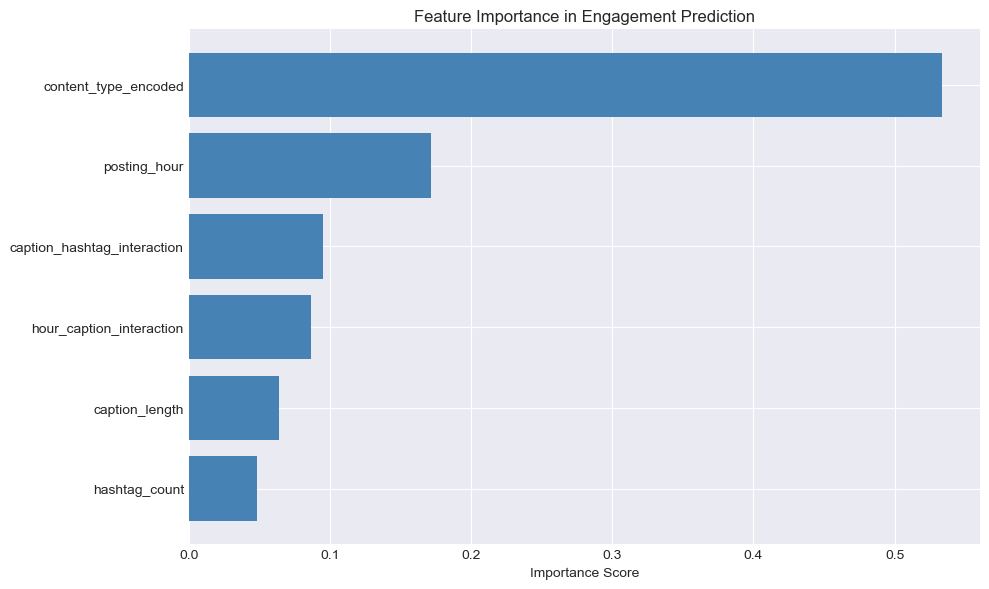

In [25]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

# Calculate total engagement metric (sum of likes, comments, and shares)
df["engagement"] = df["likes"] + df["comments"] + df["shares"]

# Calculate engagement rate (engagement per unit of content characteristics)
# This helps normalize engagement across different content types
df["engagement_rate"] = df["engagement"] / (df["caption_length"] + df["hashtag_count"] + 1)

# Encode categorical content type to numerical format for machine learning
encoder = LabelEncoder()
if 'content_type' in df.columns:
    df["content_type_encoded"] = encoder.fit_transform(df["content_type"])
else:
    # If content_type doesn't exist, create a dummy variable
    df["content_type_encoded"] = 0

# Create interaction features (these often improve model performance)
df["caption_hashtag_interaction"] = df["caption_length"] * df["hashtag_count"]
df["hour_caption_interaction"] = df["posting_hour"] * df["caption_length"]

# Normalize features for clustering (important for KMeans)
scaler_for_clustering = StandardScaler()
features_for_clustering = ["caption_length", "hashtag_count", "engagement"]
scaled_features = scaler_for_clustering.fit_transform(df[features_for_clustering])

# Determine optimal number of clusters (for small datasets, use 3)
optimal_clusters = min(3, len(df) // 2)  # Ensure we don't have more clusters than data points

# Perform KMeans clustering to identify content groups with similar characteristics
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df["content_cluster"] = kmeans.fit_predict(scaled_features)

# Display cluster characteristics
print("Content Cluster Analysis:")
print(df.groupby("content_cluster").agg({
    "engagement": ["mean", "std"],
    "caption_length": "mean",
    "hashtag_count": "mean",
    "posting_hour": "mean"
}).round(2))

# ============================================================================
# MODEL PREPARATION AND TRAINING
# ============================================================================

# Select features for prediction model (including base features and interactions)
feature_columns = ["content_type_encoded", "caption_length", "hashtag_count", 
                   "posting_hour", "caption_hashtag_interaction", "hour_caption_interaction"]

# Ensure all required columns exist
for col in feature_columns:
    if col not in df.columns:
        df[col] = 0

X = df[feature_columns]
y = df["engagement"]

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Initialize and train Random Forest Regressor
# Random Forest is robust and handles non-linear relationships well
model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)
model.fit(X_train, y_train)

# Make predictions on both training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ============================================================================
# MODEL EVALUATION
# ============================================================================

print("\n" + "="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# Calculate various evaluation metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTraining Set:")
print(f"  Mean Absolute Error (MAE): {train_mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): {train_rmse:.2f}")
print(f"  R-squared (R²): {train_r2:.4f}")

print(f"\nTest Set:")
print(f"  Mean Absolute Error (MAE): {test_mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): {test_rmse:.2f}")
print(f"  R-squared (R²): {test_r2:.4f}")

# Perform cross-validation for more robust evaluation
cv_scores = cross_val_score(model, X, y, cv=min(5, len(df)//2), scoring='r2')
print(f"\nCross-Validation R² Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance in Engagement Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [26]:
# ============================================================================
# ENHANCED RECOMMENDATION FUNCTION
# ============================================================================

def recommend_content(content_type=None, caption_length=None, hashtag_count=None, 
                      return_multiple_hours=False, top_n_hours=3):
    """
    Generate content recommendations based on user inputs and historical data analysis.
    
    Parameters:
    -----------
    content_type : str, optional
        Type of content (e.g., 'photo', 'video', 'carousel'). 
        If None, will use the most common type from the dataset.
    caption_length : int, optional
        Desired caption length in characters.
        If None, will use the average caption length from high-performing posts.
    hashtag_count : int, optional
        Number of hashtags to include.
        If None, will use the average hashtag count from high-performing posts.
    return_multiple_hours : bool, default=False
        If True, returns recommendations for multiple optimal posting hours.
    top_n_hours : int, default=3
        Number of top posting hours to return if return_multiple_hours is True.
    
    Returns:
    --------
    dict : Dictionary containing recommendations including:
        - recommended_posting_hour: Best hour to post (0-23)
        - predicted_engagement: Expected total engagement
        - optimal_caption_length: Recommended caption length
        - optimal_hashtag_count: Recommended hashtag count
        - insights: Additional insights and recommendations
        - alternative_hours: Alternative posting hours (if return_multiple_hours=True)
    """
    
    # Handle default values by analyzing high-performing posts (top 50% by engagement)
    median_engagement = df["engagement"].median()
    high_performers = df[df["engagement"] >= median_engagement]
    
    # Set default content type
    if content_type is None:
        if 'content_type' in df.columns:
            # Use the most common content type from high-performing posts
            content_type = high_performers['content_type'].mode()[0] if len(high_performers) > 0 else df['content_type'].mode()[0]
        else:
            content_type = "unknown"
    
    # Encode content type (handle unseen content types gracefully)
    try:
        ct_encoded = encoder.transform([content_type])[0]
    except (ValueError, AttributeError):
        # If content type is not in the encoder, use the most common encoded value
        if 'content_type_encoded' in df.columns:
            ct_encoded = df['content_type_encoded'].mode()[0]
        else:
            ct_encoded = 0
    
    # Set default caption length from high-performing posts
    if caption_length is None:
        caption_length = int(high_performers['caption_length'].mean()) if len(high_performers) > 0 else int(df['caption_length'].mean())
    
    # Set default hashtag count from high-performing posts
    if hashtag_count is None:
        hashtag_count = int(high_performers['hashtag_count'].mean()) if len(high_performers) > 0 else int(df['hashtag_count'].mean())
    
    # Analyze all possible posting hours to find the best ones
    hourly_predictions = []
    available_hours = sorted(df['posting_hour'].unique())
    
    for hour in available_hours:
        # Create input data for prediction
        input_data = pd.DataFrame({
            "content_type_encoded": [ct_encoded],
            "caption_length": [caption_length],
            "hashtag_count": [hashtag_count],
            "posting_hour": [hour],
            "caption_hashtag_interaction": [caption_length * hashtag_count],
            "hour_caption_interaction": [hour * caption_length]
        })
        
        # Ensure all required columns exist
        for col in feature_columns:
            if col not in input_data.columns:
                input_data[col] = 0
        
        # Predict engagement for this hour
        predicted_engagement = model.predict(input_data[feature_columns])[0]
        
        # Get historical average engagement for this hour
        historical_avg = df[df['posting_hour'] == hour]['engagement'].mean()
        
        hourly_predictions.append({
            'hour': hour,
            'predicted_engagement': predicted_engagement,
            'historical_avg': historical_avg
        })
    
    # Sort by predicted engagement and get the best hour
    hourly_predictions.sort(key=lambda x: x['predicted_engagement'], reverse=True)
    best_hour_data = hourly_predictions[0]
    
    # Find optimal caption length and hashtag count through grid search
    # (test a small range around current values)
    optimal_caption = caption_length
    optimal_hashtags = hashtag_count
    best_prediction = best_hour_data['predicted_engagement']
    
    # Test variations around the defaults
    for test_caption in [caption_length - 20, caption_length, caption_length + 20]:
        for test_hashtags in [max(1, hashtag_count - 2), hashtag_count, hashtag_count + 2]:
            if test_caption < 1:
                continue
            input_data = pd.DataFrame({
                "content_type_encoded": [ct_encoded],
                "caption_length": [test_caption],
                "hashtag_count": [test_hashtags],
                "posting_hour": [best_hour_data['hour']],
                "caption_hashtag_interaction": [test_caption * test_hashtags],
                "hour_caption_interaction": [best_hour_data['hour'] * test_caption]
            })
            
            for col in feature_columns:
                if col not in input_data.columns:
                    input_data[col] = 0
            
            test_prediction = model.predict(input_data[feature_columns])[0]
            if test_prediction > best_prediction:
                best_prediction = test_prediction
                optimal_caption = test_caption
                optimal_hashtags = test_hashtags
    
    # Get insights about best performing content cluster
    cluster_performance = df.groupby("content_cluster")["engagement"].mean().sort_values(ascending=False)
    best_cluster = cluster_performance.index[0]
    
    # Prepare insights
    insights = []
    insights.append(f"Best posting hour ({int(best_hour_data['hour'])}:00) shows {best_hour_data['predicted_engagement']:.0f} predicted engagement")
    
    if optimal_caption != caption_length or optimal_hashtags != hashtag_count:
        insights.append(f"Optimized caption length: {optimal_caption} characters (vs {caption_length} provided)")
        insights.append(f"Optimized hashtag count: {optimal_hashtags} (vs {hashtag_count} provided)")
    
    # Compare with dataset statistics
    avg_engagement = df['engagement'].mean()
    if best_prediction > avg_engagement * 1.2:
        insights.append(f"This configuration is predicted to perform {((best_prediction/avg_engagement - 1) * 100):.1f}% above average!")
    elif best_prediction < avg_engagement * 0.8:
        insights.append(f"Warning: This configuration may perform below average. Consider adjusting content strategy.")
    
    # Build result dictionary
    result = {
        "recommended_posting_hour": int(best_hour_data['hour']),
        "predicted_engagement": int(best_prediction),
        "optimal_caption_length": int(optimal_caption),
        "optimal_hashtag_count": int(optimal_hashtags),
        "best_content_cluster": int(best_cluster),
        "insights": insights,
        "historical_avg_engagement_at_hour": float(best_hour_data['historical_avg'])
    }
    
    # Add alternative hours if requested
    if return_multiple_hours:
        result["alternative_hours"] = [
            {
                "hour": int(pred['hour']),
                "predicted_engagement": int(pred['predicted_engagement']),
                "historical_avg": float(pred['historical_avg'])
            }
            for pred in hourly_predictions[:top_n_hours]
        ]
    
    return result


In [27]:
# ============================================================================
# TEST RECOMMENDATIONS WITH SPECIFIC INPUTS
# ============================================================================

# Example 1: Get recommendation with specific parameters
print("RECOMMENDATION EXAMPLE 1: Specific Content Parameters")
print("="*60)

# Try with actual content type from dataset if available
if 'content_type' in df.columns:
    test_content_type = df['content_type'].iloc[0]
    test_caption = 150
    test_hashtags = 8
else:
    test_content_type = None
    test_caption = 150
    test_hashtags = 8

rec1 = recommend_content(
    content_type=test_content_type,
    caption_length=test_caption,
    hashtag_count=test_hashtags,
    return_multiple_hours=True
)

print(f"\nInput Parameters:")
print(f"  Content Type: {test_content_type if test_content_type else 'Auto-selected'}")
print(f"  Caption Length: {test_caption} characters")
print(f"  Hashtag Count: {test_hashtags}")

print(f"\nRecommendations:")
print(f"  Best Posting Hour: {rec1['recommended_posting_hour']}:00")
print(f"  Predicted Engagement: {rec1['predicted_engagement']}")
print(f"  Optimal Caption Length: {rec1['optimal_caption_length']} characters")
print(f"  Optimal Hashtag Count: {rec1['optimal_hashtag_count']}")

print(f"\nInsights:")
for insight in rec1['insights']:
    print(f"  • {insight}")

print(f"\nTop {len(rec1['alternative_hours'])} Alternative Posting Hours:")
for alt in rec1['alternative_hours']:
    print(f"  Hour {alt['hour']}:00 - Predicted: {alt['predicted_engagement']}, Historical Avg: {alt['historical_avg']:.1f}")


RECOMMENDATION EXAMPLE 1: Specific Content Parameters

Input Parameters:
  Content Type: photo
  Caption Length: 150 characters
  Hashtag Count: 8

Recommendations:
  Best Posting Hour: 21:00
  Predicted Engagement: 224
  Optimal Caption Length: 170 characters
  Optimal Hashtag Count: 10

Insights:
  • Best posting hour (21:00) shows 213 predicted engagement
  • Optimized caption length: 170 characters (vs 150 provided)
  • Optimized hashtag count: 10 (vs 8 provided)

Top 3 Alternative Posting Hours:
  Hour 21:00 - Predicted: 213, Historical Avg: 375.5
  Hour 20:00 - Predicted: 200, Historical Avg: 278.0
  Hour 19:00 - Predicted: 192, Historical Avg: 259.8
